ℓ1 Total Variation Denoising
============================

This example demonstrates impulse noise removal via ℓ1 total variation
<cite data-cite="alliney-1992-digital"/> <cite data-cite="esser-2010-primal"/> (Sec. 2.4.4)
(i.e. total variation regularization with an ℓ1 data fidelity term),
minimizing the functional

  $$\mathrm{argmin}_{\mathbf{x}} \;  \| \mathbf{y} - \mathbf{x}
  \|_1 + \lambda \| C \mathbf{x} \|_{2,1} \;,$$

where $\mathbf{y}$ is the noisy image, $C$ is a 2D finite difference
operator, and $\mathbf{x}$ is the denoised image.

In [1]:
import jax

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.examples import spnoise
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
from scipy.ndimage import median_filter
plot.config_notebook_plotting()

Create a ground truth image and impose salt & pepper noise to create a
noisy test image.

In [2]:
N = 256  # image size
phantom = SiemensStar(16)
x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)
x_gt = 0.5 * x_gt / x_gt.max()
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU
y = spnoise(x_gt, 0.5)

Denoise with median filtering.

In [3]:
x_med = median_filter(y, size=(5, 5))

Denoise with ℓ1 total variation.

In [4]:
λ = 1.5e0
g_loss = loss.Loss(y=y, f=functional.L1Norm())
g_tv = λ * functional.L21Norm()
# The append=0 option makes the results of horizontal and vertical finite
# differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)

solver = ADMM(
    f=None,
    g_list=[g_loss, g_tv],
    C_list=[linop.Identity(input_shape=y.shape), C],
    rho_list=[5e0, 5e0],
    x0=y,
    maxiter=100,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 20}),
    itstat_options={"display": True, "period": 10},
)

print(f"Solving on {device_info()}\n")
x_tv = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.33e+00  4.255e+04  6.265e+01  1.351e+02      0  0.000e+00


  10  2.94e+00  1.807e+04  5.394e+00  6.268e+00      8  9.359e-04


  20  3.09e+00  1.802e+04  5.985e-01  1.021e+00      5  5.799e-04
  30  3.22e+00  1.802e+04  2.047e-01  3.239e-01      3  6.929e-04


  40  3.31e+00  1.802e+04  1.077e-01  1.476e-01      2  7.048e-04
  50  3.38e+00  1.802e+04  7.378e-02  4.794e-02      1  9.994e-04
  60  3.44e+00  1.802e+04  5.815e-02  4.041e-02      1  9.447e-04


  70  3.51e+00  1.802e+04  4.710e-02  3.101e-02      1  8.223e-04
  80  3.58e+00  1.802e+04  3.855e-02  2.652e-02      1  7.110e-04
  90  3.64e+00  1.802e+04  3.254e-02  2.390e-02      1  6.308e-04
  99  3.70e+00  1.802e+04  2.821e-02  2.166e-02      1  5.759e-04


Plot results.

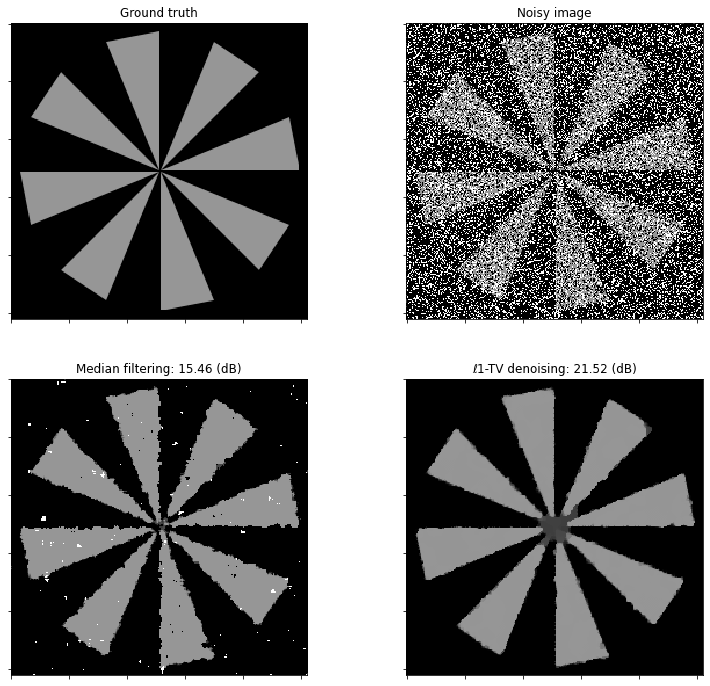

In [5]:
plt_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.0))
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(13, 12))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy image", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(
    x_med,
    title=f"Median filtering: {metric.psnr(x_gt, x_med):.2f} (dB)",
    fig=fig,
    ax=ax[1, 0],
    **plt_args,
)
plot.imview(
    x_tv,
    title=f"ℓ1-TV denoising: {metric.psnr(x_gt, x_tv):.2f} (dB)",
    fig=fig,
    ax=ax[1, 1],
    **plt_args,
)
fig.show()

Plot convergence statistics.

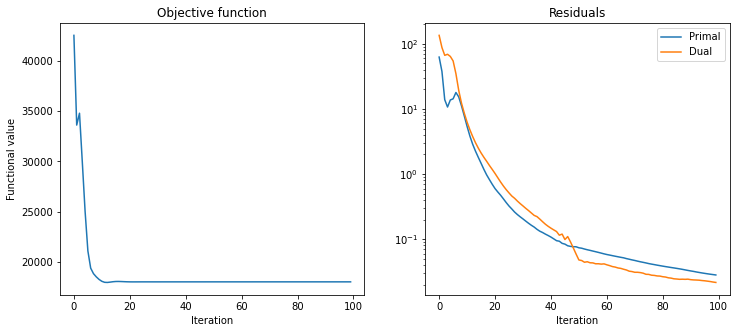

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()